In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/Clustering

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/Clustering


In [ ]:
%ls

customer-seg.csv  OnlineRetail.csv


In [ ]:
import pandas as pd

# Load the dataset
retail_data = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')

# Display the first few rows of the dataset to understand its structure
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Aggregate data at the customer level to analyze patterns like total spending, average unit price, and purchase frequency. These metrics provide a good overview of customer behavior and are suitable for clustering.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Aggregating data at the customer level
customer_data = retail_data.groupby('CustomerID').agg(
    TotalSpending=pd.NamedAgg(column='UnitPrice', aggfunc=lambda x: np.sum(x * retail_data.loc[x.index, 'Quantity'])),
    AverageUnitPrice=pd.NamedAgg(column='UnitPrice', aggfunc='mean'),
    PurchaseFrequency=pd.NamedAgg(column='InvoiceNo', aggfunc=pd.Series.nunique)
)

# Handling missing values - replacing them with the mean of the respective column
customer_data.fillna(customer_data.mean(), inplace=True)

# Normalizing the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)

# Displaying the first few rows of the processed data
customer_data.head()

,TotalSpending,AverageUnitPrice,PurchaseFrequency
CustomerID,,,
12346.0,0.00,1.040000,2
12347.0,4310.00,2.644011,7
12348.0,1797.24,5.764839,4
12349.0,1757.55,8.289041,1
12350.0,334.40,3.841176,1


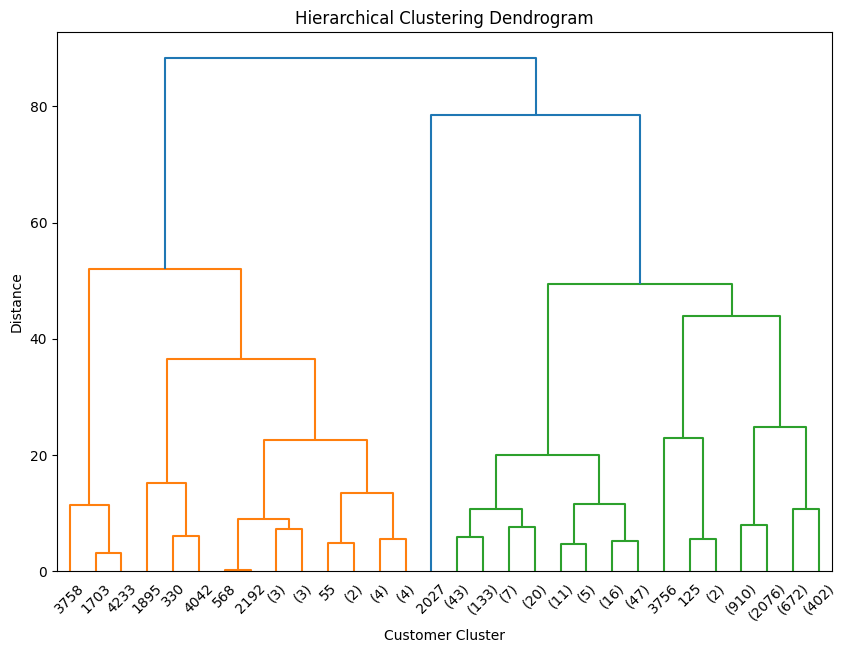

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Performing hierarchical clustering
Z = linkage(customer_data_scaled, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, truncate_mode='level', p=5)  # 'p' controls the number of levels we want to display in the plot
plt.xlabel('Customer Cluster')
plt.ylabel('Distance')
plt.show()

The dendrogram above represents the hierarchical clustering of customers based on their spending behavior, average unit price, and purchase frequency. Each branch represents a customer or a cluster of customers, and the height of the branches indicates the distance or dissimilarity between clusters.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Choosing the number of clusters
# We can either specify a number of clusters directly, or use a threshold for distance to cut the dendrogram
# For demonstration, let's use a threshold to cut the dendrogram
threshold = 150
clusters = fcluster(Z, threshold, criterion='distance')

# Adding the cluster labels to the original customer data
customer_data['Cluster'] = clusters

# Displaying the first few rows with the cluster labels
customer_data.head()

,TotalSpending,AverageUnitPrice,PurchaseFrequency,Cluster
CustomerID,,,,
12346.0,0.00,1.040000,2,1
12347.0,4310.00,2.644011,7,1
12348.0,1797.24,5.764839,4,1
12349.0,1757.55,8.289041,1,1
12350.0,334.40,3.841176,1,1


In [ ]:
# Analyzing the characteristics of each cluster
cluster_analysis = customer_data.groupby('Cluster').agg(
    AverageTotalSpending=pd.NamedAgg(column='TotalSpending', aggfunc='mean'),
    AverageUnitPrice=pd.NamedAgg(column='AverageUnitPrice', aggfunc='mean'),
    AveragePurchaseFrequency=pd.NamedAgg(column='PurchaseFrequency', aggfunc='mean'),
    NumberOfCustomers=pd.NamedAgg(column='Cluster', aggfunc='count')
)

cluster_analysis

,AverageTotalSpending,AverageUnitPrice,AveragePurchaseFrequency,NumberOfCustomers
Cluster,,,,
1,1898.459701,7.978608,5.07548,4372


Since all customers are grouped into a single cluster (Cluster 1), it suggests that the chosen threshold for clustering might be too high, leading to less differentiation between customer behaviors. Alternatively, it could indicate that the customer base is relatively homogeneous in terms of the selected metrics.

We should adjust the threshold


In [ ]:
# Adjusting the threshold to create more clusters
# Using a lower threshold value
lower_threshold = 50
clusters_adjusted = fcluster(Z, lower_threshold, criterion='distance')

# Adding the adjusted cluster labels to the customer data
customer_data['Cluster_Adjusted'] = clusters_adjusted

# Reanalyzing the characteristics of each adjusted cluster
cluster_analysis_adjusted = customer_data.groupby('Cluster_Adjusted').agg(
    AverageTotalSpending=pd.NamedAgg(column='TotalSpending', aggfunc='mean'),
    AverageUnitPrice=pd.NamedAgg(column='AverageUnitPrice', aggfunc='mean'),
    AveragePurchaseFrequency=pd.NamedAgg(column='PurchaseFrequency', aggfunc='mean'),
    NumberOfCustomers=pd.NamedAgg(column='Cluster_Adjusted', aggfunc='count')
)

cluster_analysis_adjusted

,AverageTotalSpending,AverageUnitPrice,AveragePurchaseFrequency,NumberOfCustomers
Cluster_Adjusted,,,,
1,241136.560000,7.988403,64.666667,3
2,56018.827727,7.528639,85.000000,22
3,1459.639306,6.129107,4.629775,4346
4,649.500000,8055.780000,5.000000,1


    Cluster 1
        Average Total Spending: Very high, at approximately £241,136.56 per customer.
        Average Unit Price: Around £7.99.
        Average Purchase Frequency: Very high, with around 65 purchases.
        Number of Customers: A very small group, with only 3 customers.

    Cluster 2
        Average Total Spending: High, at about £56,018.83 per customer.
        Average Unit Price: Approximately £7.53.
        Average Purchase Frequency: Extremely high, with an average of 85 purchases.
        Number of Customers: 22 customers.

    Cluster 3
        Average Total Spending: Moderate, at about £1,459.64 per customer.
        Average Unit Price: Around £6.13.
        Average Purchase Frequency: Relatively low, with around 5 purchases.
        Number of Customers: The largest cluster with 4,346 customers.

    Cluster 4
        Average Total Spending: £649.50 per customer.
        Average Unit Price: Exceptionally high, at £8,055.78 (this might indicate a data anomaly or a very specific purchasing pattern).
        Average Purchase Frequency: 5 purchases.
        Number of Customers: Only 1 customer.

This clustering provides a more nuanced view of the customer base, identifying distinct segments ranging from high-value frequent purchasers to more typical customers with moderate spending and purchase frequency. The extremely high average unit price in Cluster 4 suggests a potential data anomaly or a very specific type of purchase, which might warrant further investigation.